In [285]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import fbeta_score, make_scorer,confusion_matrix,accuracy_score
import time as time
from sklearn.svm import SVC

In [286]:
my_file = Path("train.csv")
if my_file.is_file()==False:
  !wget 'https://raw.githubusercontent.com/Bahaakhalled/Spaceship-Titanic/main/train.csv'
  !wget 'https://raw.githubusercontent.com/Bahaakhalled/Spaceship-Titanic/main/test.csv'

In [287]:
ship=pd.read_csv('train.csv')
test_ship=pd.read_csv('test.csv')
ship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [288]:
ship.shape

(8693, 14)

In [289]:
ship.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


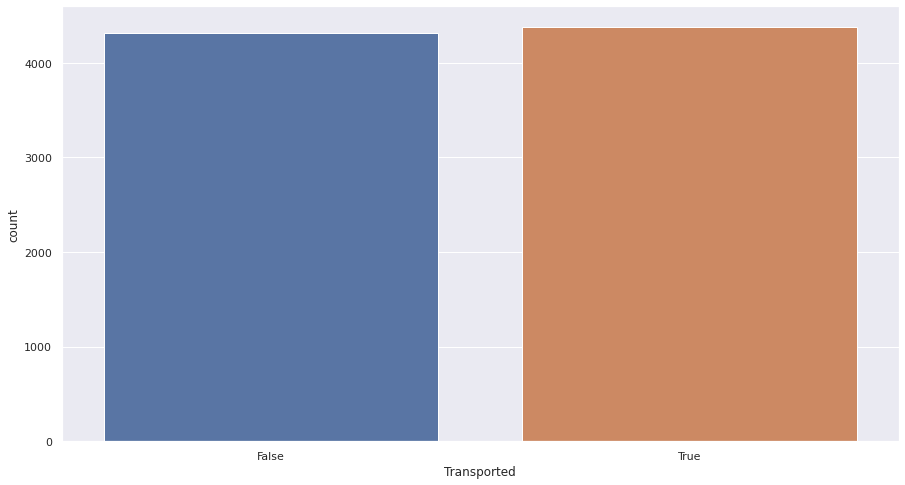

In [290]:
sns.countplot(x="Transported", data=ship)

In [291]:
ship['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

In [292]:
ship.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [293]:
missing=(ship.isnull().sum().sum()/np.product(ship.shape) ) * 100
print('Data Missing: ',missing,'%')

Data Missing:  1.9095824226389047 %


In [294]:
print(int(missing),' % of the cells are missing is low but that is',ship.shape[0] - ship.dropna().shape[0],'out of the',ship.shape[0],'rows given')

1  % of the cells are missing is low but that is 2087 out of the 8693 rows given


In [295]:
miss_cols=ship.columns[ship.isnull().sum()>0]
miss_cols=ship[miss_cols]
miss_cols={'Features': miss_cols.isnull().sum().index,'Missing%':miss_cols.isnull().sum()}
miss_cols=pd.DataFrame(data=miss_cols).reset_index().drop('index',axis=1)
miss_cols['Missing%']=miss_cols['Missing%'].apply(lambda m:(m/ship.shape[0])*100)
miss_cols=miss_cols.sort_values(by='Missing%',ascending=False)
miss_cols

,Features,Missing%
1,CryoSleep,2.496261
8,ShoppingMall,2.392730
5,VIP,2.335212
0,HomePlanet,2.312205
11,Name,2.300702
2,Cabin,2.289198
10,VRDeck,2.162660
7,FoodCourt,2.105142
9,Spa,2.105142
3,Destination,2.093639


In [296]:
c_ship=ship.copy()

In [297]:
twoval_cols=c_ship.loc[:, c_ship.nunique() ==2].columns
print('Columns with True/False Results: ',twoval_cols)
twoval_map = {True: 1, False: 0}
for i in twoval_cols:
  c_ship[i] = c_ship[i].map(twoval_map)

Columns with True/False Results:  Index(['CryoSleep', 'VIP', 'Transported'], dtype='object')


First Aprroach is removing the 2 percent missing Items however the two percents represent 2087 rows from the total of

In [298]:
c_ship[miss_cols.Features].describe()

,CryoSleep,ShoppingMall,VIP,VRDeck,FoodCourt,Spa,RoomService,Age
count,8476.000000,8485.000000,8490.000000,8505.000000,8510.000000,8510.000000,8512.000000,8514.000000
mean,0.358306,173.729169,0.023439,304.854791,458.077203,311.138778,224.687617,28.827930
std,0.479531,604.696458,0.151303,1145.717189,1611.489240,1136.705535,666.717663,14.489021
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000
75%,1.000000,27.000000,0.000000,46.000000,76.000000,59.000000,47.000000,38.000000
max,1.000000,23492.000000,1.000000,24133.000000,29813.000000,22408.000000,14327.000000,79.000000


In [299]:
c_ship_miss = c_ship.dropna(axis=0)
c_ship_miss=c_ship_miss.reset_index().drop('index',axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa19143bf10>,
      dtype=object)

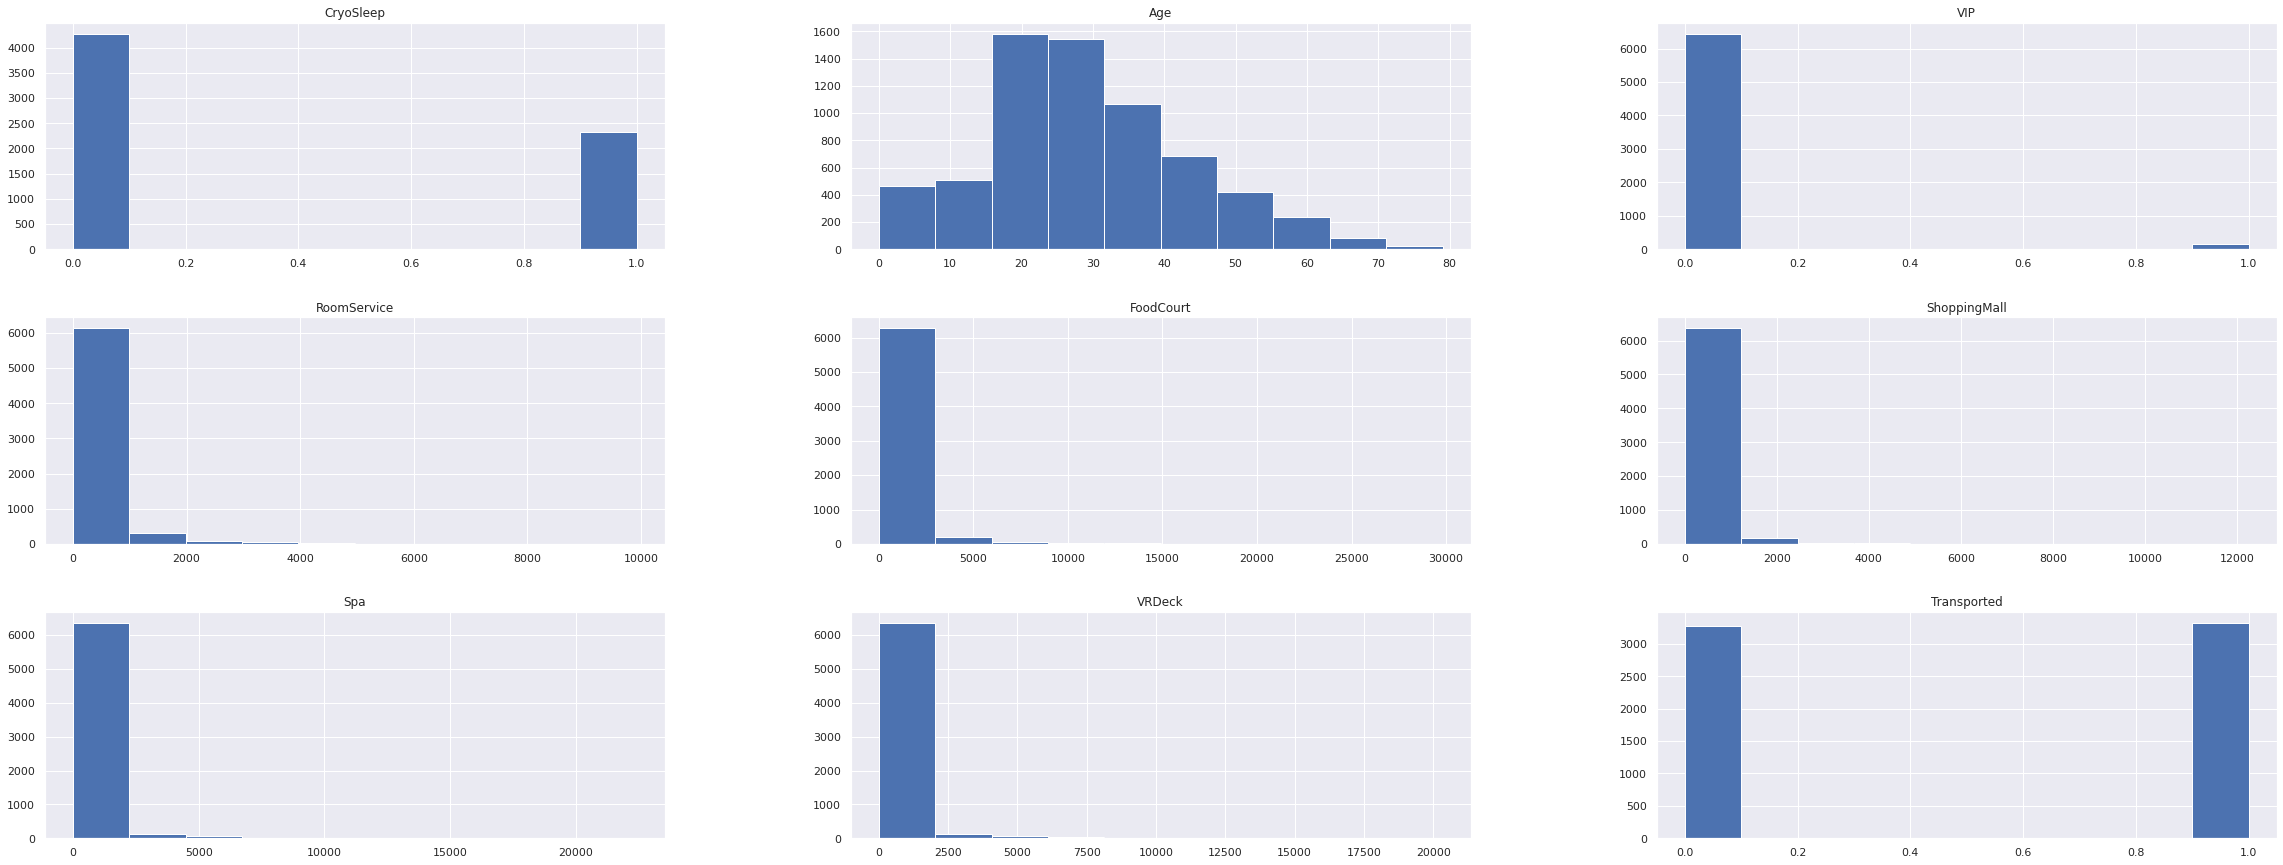

In [300]:
c_ship_miss.hist(figsize=(40, 15))

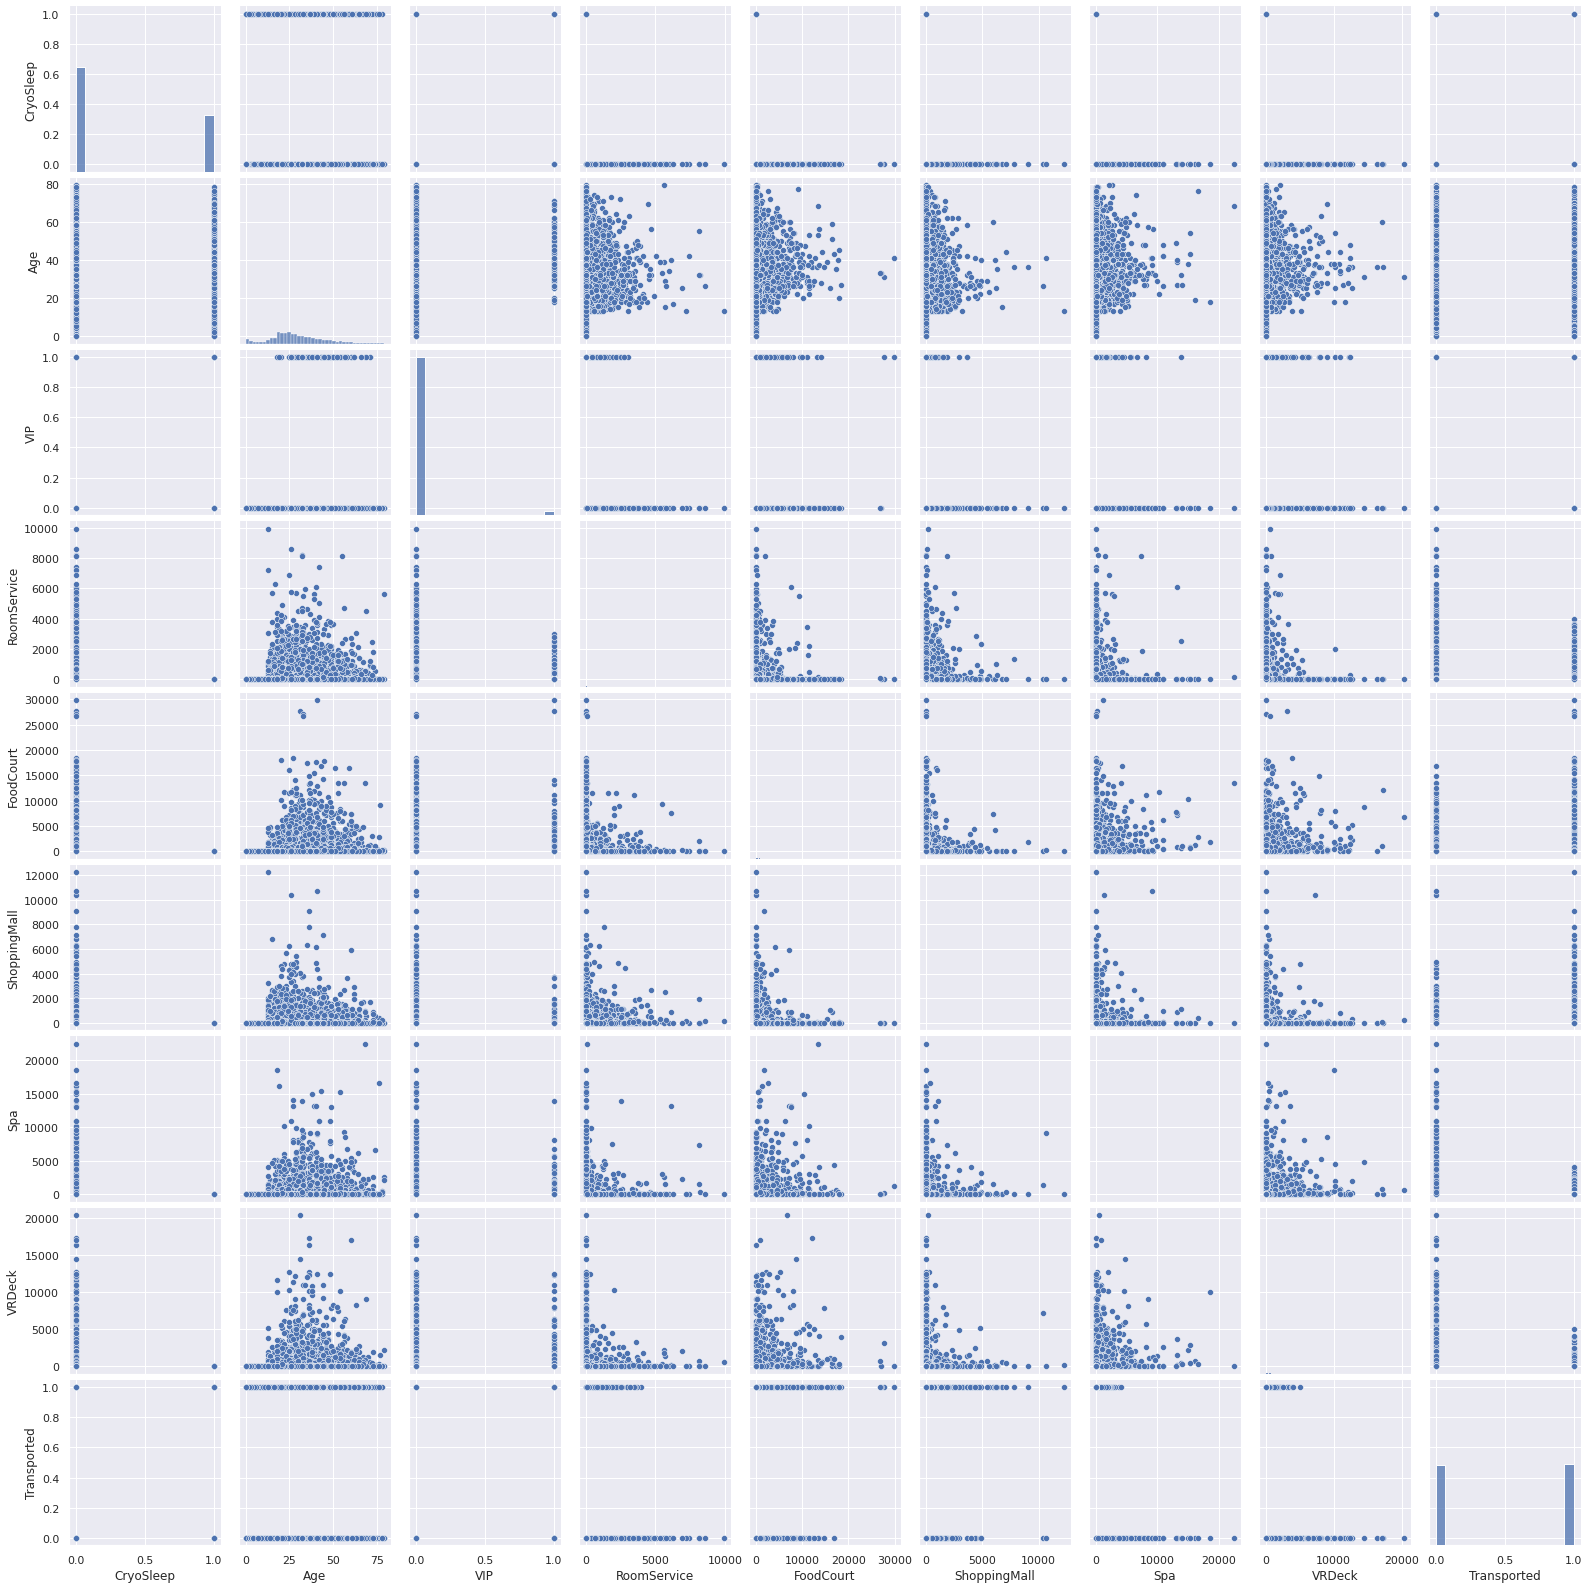

In [301]:
sns.pairplot(data=c_ship_miss)

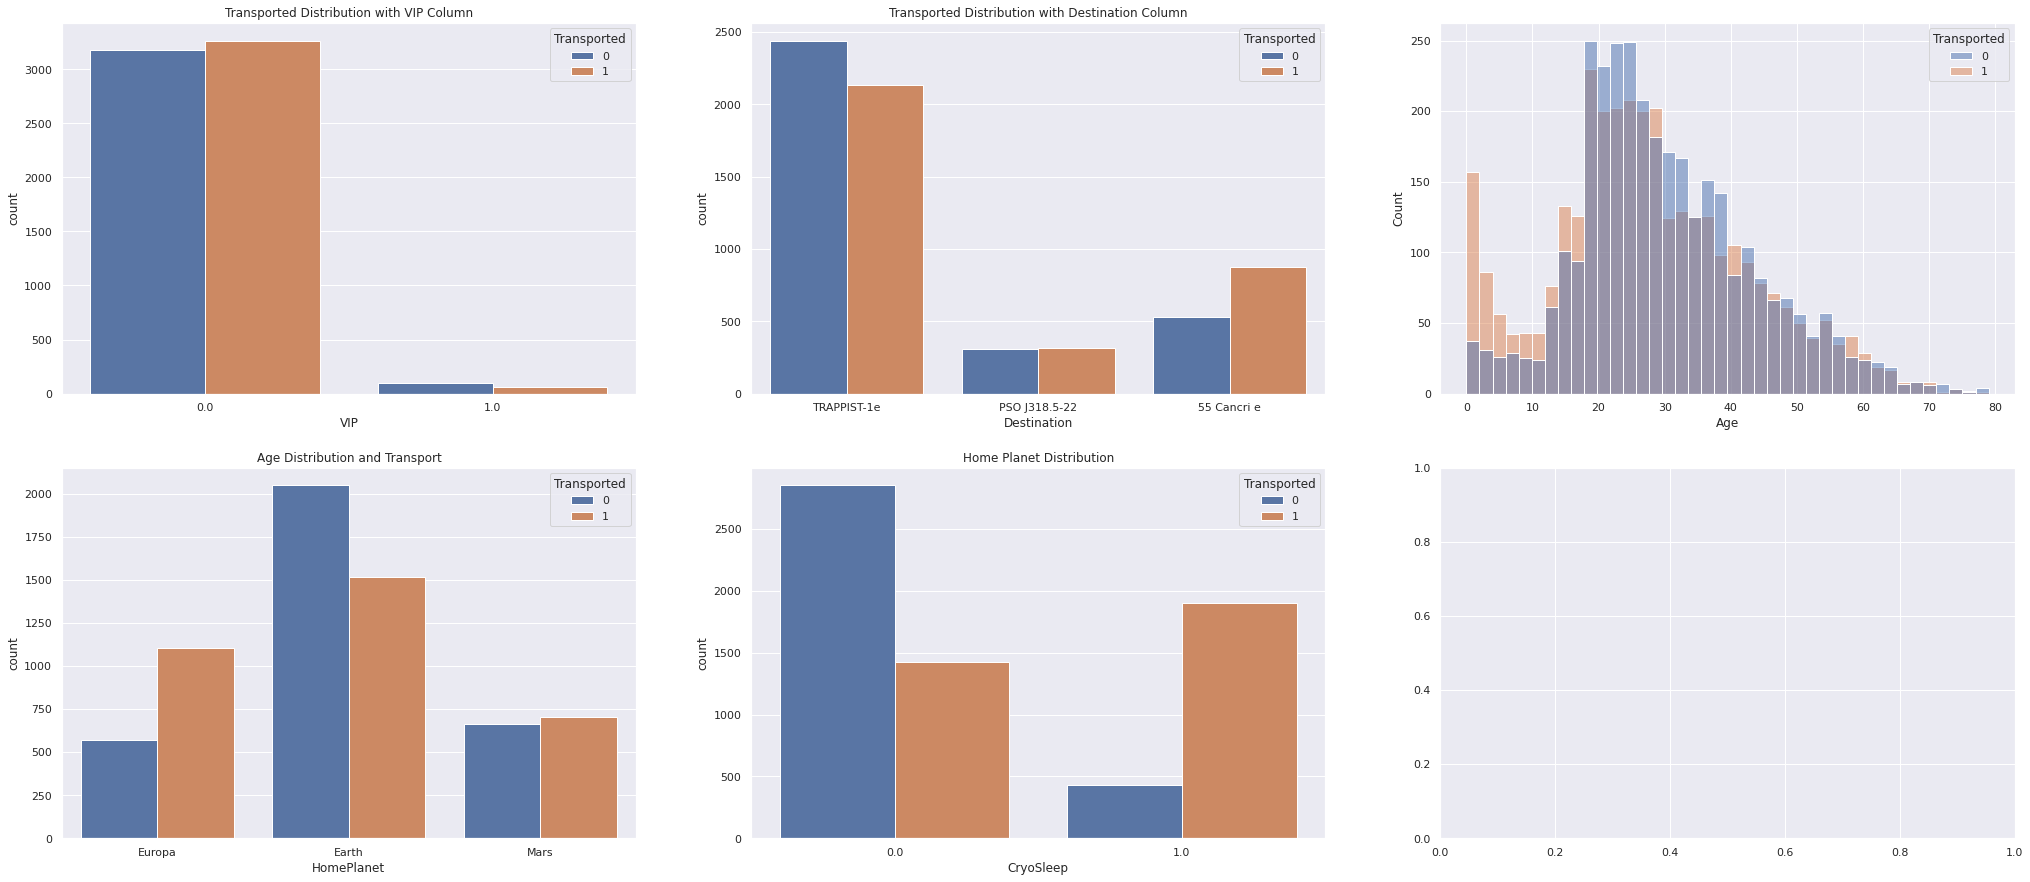

In [302]:
figure, axis = plt.subplots(2, 3,figsize=(35,15))

sns.countplot(ax=axis[0,0],data=c_ship_miss,x='VIP',hue='Transported')
axis[0, 0].set_title("Transported Distribution with VIP Column")
  
sns.countplot(ax=axis[0,1],data=c_ship_miss,x='Destination',hue='Transported')
axis[0, 1].set_title("Transported Distribution with Destination Column")
  
sns.histplot(ax=axis[0,2],data=c_ship_miss, x="Age",hue="Transported")
axis[1, 0].set_title("Age Distribution and Transport")
  
sns.countplot(ax=axis[1,0],x ='HomePlanet', data = c_ship_miss,hue='Transported')
axis[1, 1].set_title("Home Planet Distribution")

sns.countplot(ax=axis[1,1],x ='CryoSleep', data = c_ship_miss,hue='Transported')
axis[1, 1].set_title("Home Planet Distribution")
plt.show()

In [303]:
total_age=c_ship_miss.groupby('Age').PassengerId.count()
total_age=pd.DataFrame(total_age).reset_index()
total_age=total_age.rename(columns={'PassengerId':'Total_Age'})
agegroup=c_ship_miss.groupby(['Age','Transported']).PassengerId.count()
agegroup=pd.DataFrame(agegroup)
agegroup=agegroup.reset_index()

In [304]:
age_stats=pd.merge(agegroup,total_age, on='Age')
age_stats['Age Survival %']=(age_stats['PassengerId']/age_stats['Total_Age'])*100
survived=age_stats.loc[age_stats['Transported']==1].sort_values(by=['Age Survival %','PassengerId'],ascending=False)

In [305]:
bin1=survived.loc[survived.Age<20]
bin2=survived.loc[(survived.Age>20) & (survived.Age<40)]
bin3=survived.loc[(survived.Age>40) & (survived.Age<60)]
bin4=survived.loc[survived.Age>60]
bin1=bin1['Age Survival %'].sum()/bin1.shape[0]
bin2=bin2['Age Survival %'].sum()/bin2.shape[0]
bin3=bin3['Age Survival %'].sum()/bin3.shape[0]
bin4=bin4['Age Survival %'].sum()/bin4.shape[0]
Bins={'Age Group':['0-20','20-40','40-60','60-80'],'Survival Rate':[bin1,bin2,bin3,bin4]}
sur=pd.DataFrame(data=Bins)
sur

,Age Group,Survival Rate
0,0-20,62.861828
1,20-40,46.001919
2,40-60,49.794652
3,60-80,51.078146


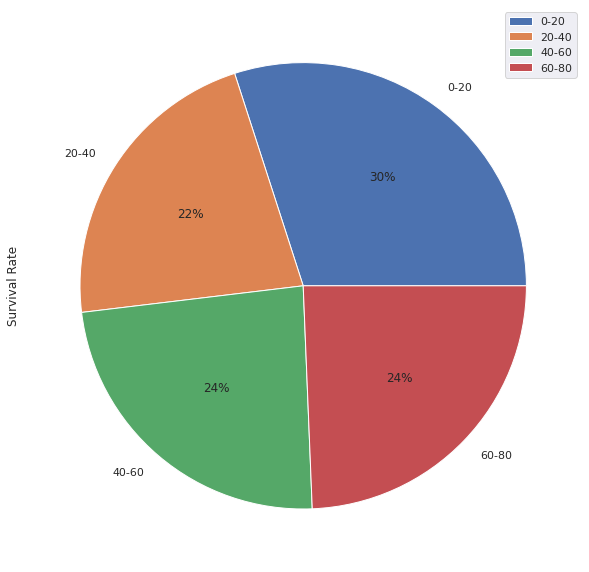

In [306]:
sur.plot(kind='pie',y='Survival Rate',labels=sur['Age Group'], autopct='%1.0f%%',figsize=(10, 15))

In [307]:
Luxurycols=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Transported']

In [308]:
c_ship_miss[Luxurycols].corr()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
RoomService,1.000000,-0.013614,0.060478,0.012472,-0.026002,-0.247291
FoodCourt,-0.013614,1.000000,-0.012320,0.215995,0.216997,0.055025
ShoppingMall,0.060478,-0.012320,1.000000,0.022168,0.000383,0.011602
Spa,0.012472,0.215995,0.022168,1.000000,0.149447,-0.219854
VRDeck,-0.026002,0.216997,0.000383,0.149447,1.000000,-0.207950
Transported,-0.247291,0.055025,0.011602,-0.219854,-0.207950,1.000000


In [309]:
split=c_ship_miss['Cabin'].str.split('/')
deck=list()
num=list()
side=list()
for i in range(split.shape[0]):
  #print(i)
  deck.append(split[i][0])
  num.append(split[i][1])
  side.append(split[i][2])
c_ship_miss['Cabin_Deck']=deck
c_ship_miss['Cabin_Number']=num
c_ship_miss['Cabin_Side']=side
c_ship_miss.drop('Cabin',axis=1,inplace=True)

In [310]:
Cabin_details=['Cabin_Deck','Cabin_Number','Cabin_Side']
c_ship_miss[Cabin_details].nunique()

Cabin_Deck         8
Cabin_Number    1734
Cabin_Side         2
dtype: int64

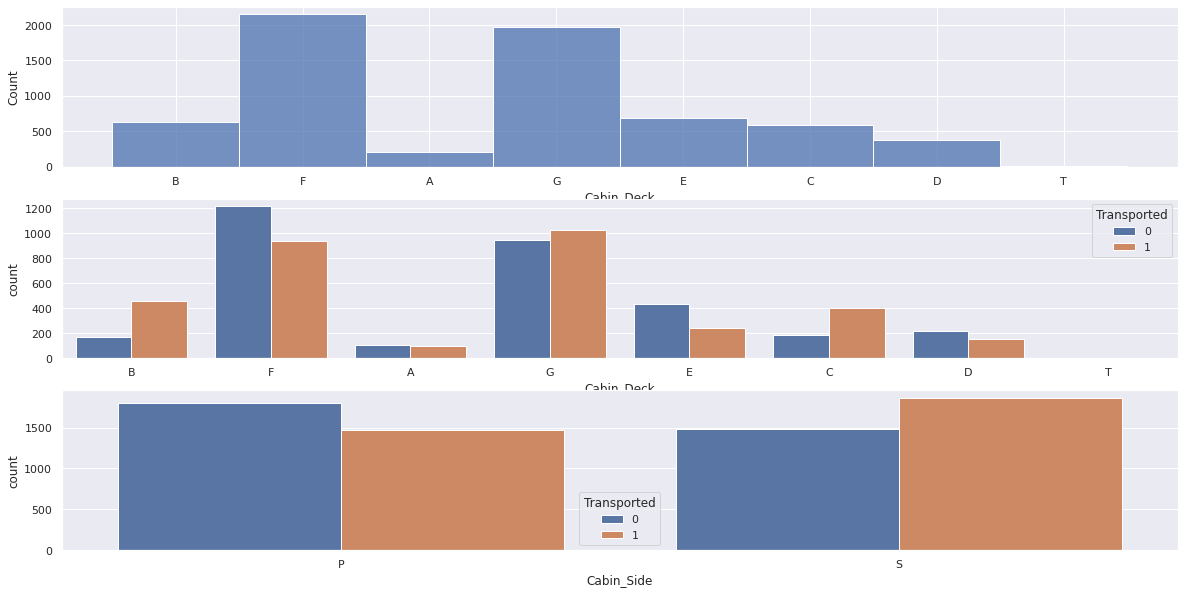

In [311]:
figure, axis = plt.subplots(3, 1,figsize=(20,10))
sns.histplot(ax=axis[0],data=c_ship_miss, x="Cabin_Deck")
sns.countplot(ax=axis[1],data=c_ship_miss,x='Cabin_Deck',hue='Transported')
sns.countplot(ax=axis[2],data=c_ship_miss,x='Cabin_Side',hue='Transported')

In [312]:
c_ship_miss.Cabin_Side.value_counts()

S    3345
P    3261
Name: Cabin_Side, dtype: int64

In [313]:
Features=['HomePlanet', 'CryoSleep','Destination', 'Age','VIP','Cabin_Side','Cabin_Deck']
X=c_ship_miss[Features]
y=c_ship_miss['Transported']

In [314]:
X

,HomePlanet,CryoSleep,Destination,Age,VIP,Cabin_Side,Cabin_Deck
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,P,B
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,S,F
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,S,A
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,S,A
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,S,F
...,...,...,...,...,...,...,...
6601,Europa,0.0,55 Cancri e,41.0,1.0,P,A
6602,Earth,1.0,PSO J318.5-22,18.0,0.0,S,G
6603,Earth,0.0,TRAPPIST-1e,26.0,0.0,S,G
6604,Europa,0.0,55 Cancri e,32.0,0.0,S,E


In [315]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
def predictbasicmodels(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  print("X set has {} samples.".format(X.shape))
  print("Training set has {} samples.".format(X_train.shape[0]))
  print("Testing set has {} samples.".format(X_test.shape[0]))
  print()
  clf_A = SVC(random_state=3)
  clf_B = LogisticRegression(random_state=3)
  clf_C = GaussianNB()

  results = {}
  for clf in [clf_A, clf_B, clf_C]:
      clf_name = clf.__class__.__name__
      results[clf_name] = {}
      results[clf_name] = \
      results = {}
      clf = clf.fit(X_train, y_train)
        
      predictions_test = clf.predict(X_test)
      print(clf)
      print('Accuracy Score: ' + str(accuracy_score(y_test,predictions_test)))
      print('fb Score: '+ str(fbeta_score(y_test,predictions_test,beta=0.5)))
      print()
  return X_train, X_test, y_train, y_test

import lightgbm as lgb

def predictadvmodels(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  print("Training set has {} samples.".format(X_train.shape[0]))
  print("Testing set has {} samples.".format(X_test.shape[0]))
  print()
  clf_A = GradientBoostingClassifier(random_state=3)
  clf_B = xgb.XGBClassifier(random_state=3)
  clf_C = RandomForestClassifier(random_state=3)

  results = {}
  for clf in [clf_A, clf_B, clf_C]:
      clf_name = clf.__class__.__name__
      results[clf_name] = {}
      results[clf_name] = \
      results = {}
      clf = clf.fit(X_train, y_train)
        
      predictions_test = clf.predict(X_test)
      print(clf)
      print('Accuracy Score: ' + str(accuracy_score(y_test,predictions_test)))
      print('fb Score: '+ str(fbeta_score(y_test,predictions_test,beta=0.5)))
      print()
  return X_train, X_test, y_train, y_test

In [316]:
X=pd.get_dummies(X,drop_first=True)
X_train, X_test, y_train, y_test=predictbasicmodels(X,y)

X set has (6606, 15) samples.
Training set has 5284 samples.
Testing set has 1322 samples.

SVC(random_state=3)
Accuracy Score: 0.7299546142208775
fb Score: 0.7541899441340782

LogisticRegression(random_state=3)
Accuracy Score: 0.7344931921331316
fb Score: 0.7493984187005843

GaussianNB()
Accuracy Score: 0.7155824508320726
fb Score: 0.7250250584697628



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [317]:
X_train, X_test, y_train, y_test=predictadvmodels(X,y)

Training set has 5284 samples.
Testing set has 1322 samples.

GradientBoostingClassifier(random_state=3)
Accuracy Score: 0.75642965204236
fb Score: 0.7800785433773654

XGBClassifier(random_state=3)
Accuracy Score: 0.7526475037821483
fb Score: 0.7754010695187167

RandomForestClassifier(random_state=3)
Accuracy Score: 0.6913767019667171
fb Score: 0.6925207756232687



In [318]:
def Gridsrch(clf):

  parameters={'n_estimators':[50,100,200],'learning_rate':[0.1,0.01,0.15,0.001]}
  scorer=make_scorer(accuracy_score)
  grid_layout=GridSearchCV(clf,parameters,scoring=scorer)

  grid_fit=grid_layout.fit(X_train,y_train)

  best_clf=grid_fit.best_estimator_

  #predict using plane and optimized model
  predictions=(clf.fit(X_train,y_train).predict(X_test))
  best_predictions=best_clf.predict(X_test)
  print(str(clf) +" before Optimization: " + str(accuracy_score(y_test,predictions)))
  print(str(clf) +" after Optimization: " + str(accuracy_score(y_test,best_predictions)))
  print(grid_fit.best_params_)
  return grid_fit

In [319]:
grid_fit=Gridsrch(xgb.XGBClassifier(random_state=3))

XGBClassifier(random_state=3) before Optimization: 0.7526475037821483
XGBClassifier(random_state=3) after Optimization: 0.737518910741301
{'learning_rate': 0.01, 'n_estimators': 200}


In [320]:
results=pd.DataFrame(grid_fit.cv_results_)
results.sort_values(by='mean_test_score',ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.243014,0.008976,0.005525,0.000294,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.730369,0.745506,0.725639,0.738884,0.732955,0.734670,0.006902,12
6,0.123532,0.004834,0.003724,0.000139,0.15,50,"{'learning_rate': 0.15, 'n_estimators': 50}",0.735099,0.746452,0.724693,0.736991,0.732955,0.735238,0.007004,11
7,0.228862,0.005521,0.005272,0.000220,0.15,100,"{'learning_rate': 0.15, 'n_estimators': 100}",0.726585,0.748344,0.720908,0.737938,0.742424,0.735240,0.010109,10
8,0.452209,0.009278,0.009061,0.000285,0.15,200,"{'learning_rate': 0.15, 'n_estimators': 200}",0.735099,0.752129,0.719962,0.742668,0.733902,0.736752,0.010623,9
2,0.457262,0.012255,0.009084,0.000457,0.1,200,"{'learning_rate': 0.1, 'n_estimators': 200}",0.734153,0.752129,0.722800,0.736045,0.739583,0.736942,0.009446,8
9,0.126271,0.003362,0.003413,0.000230,0.001,50,"{'learning_rate': 0.001, 'n_estimators': 50}",0.726585,0.751183,0.742668,0.729423,0.737689,0.737509,0.008926,5
10,0.237329,0.004890,0.004560,0.000818,0.001,100,"{'learning_rate': 0.001, 'n_estimators': 100}",0.726585,0.751183,0.742668,0.729423,0.737689,0.737509,0.008926,5
11,0.481158,0.010727,0.006260,0.000373,0.001,200,"{'learning_rate': 0.001, 'n_estimators': 200}",0.726585,0.751183,0.742668,0.729423,0.737689,0.737509,0.008926,5
0,0.138334,0.005876,0.003825,0.000156,0.1,50,"{'learning_rate': 0.1, 'n_estimators': 50}",0.731315,0.745506,0.734153,0.741722,0.736742,0.737888,0.005122,4
3,0.130990,0.005213,0.003433,0.000072,0.01,50,"{'learning_rate': 0.01, 'n_estimators': 50}",0.728477,0.751183,0.742668,0.729423,0.737689,0.737888,0.008484,3


In [321]:
pip install scikit_optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [322]:
from skopt import BayesSearchCV
estimator=RandomForestClassifier(random_state=3)
search_space={'criterion':['entropy'],'n_estimators':[50,500],'min_samples_split':[2,20],'min_samples_leaf':[1,5],'max_features':['sqrt','log2'],'oob_score':[True],'max_depth':[10,20]}

fit_params= {
    'early_stopping_rounds': 10,
    'eval_set':[(X, y)],
    'verbose': False
}
opt = BayesSearchCV(estimator=estimator,search_spaces=search_space,fit_params=fit_params,cv=3,scoring='accuracy',random_state=42,n_iter=20)

In [324]:
opt.fit(X_train,y_train)
accuracy_score(y_test,opt.predict(X_test))

0.7655068078668684

In [325]:
opt.best_params_

OrderedDict([('criterion', 'entropy'),
             ('max_depth', 10),
             ('max_features', 'log2'),
             ('min_samples_leaf', 2),
             ('min_samples_split', 20),
             ('n_estimators', 500),
             ('oob_score', True)])

In [327]:
confusion_matrix(y_test,opt.predict(X_test))

array([[576,  85],
       [225, 436]])

In [328]:
confusion_matrix(y_test,grid_fit.best_estimator_.predict(X_test))

array([[557, 104],
       [243, 418]])

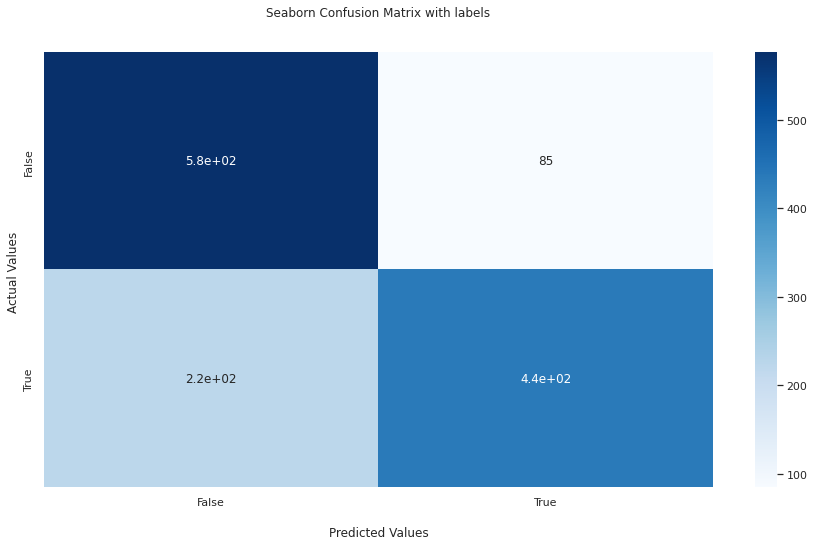

In [329]:
cm=confusion_matrix(y_test,opt.predict(X_test))
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [330]:
_test_ship=pd.read_csv('test.csv')
test_ship.shape

(4277, 13)

In [331]:
test_ship.shape[0] - test_ship.dropna().shape[0]

996

In [332]:
test_ship.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [333]:
si=SimpleImputer(strategy='most_frequent')
train_miss=pd.DataFrame(si.fit_transform(test_ship))
train_miss.columns=test_ship.columns
train_miss.index=test_ship.index
#train_miss['Cabin'] = train_miss['Cabin'].replace('missing_value', '0/0/0')

In [334]:
split=train_miss['Cabin'].str.split('/')
deck=list()
num=list()
side=list()
for i in range(split.shape[0]):
  deck.append(split[i][0])
  num.append(split[i][1])
  side.append(split[i][2])
train_miss['Cabin_Deck']=deck
train_miss['Cabin_Number']=num
train_miss['Cabin_Side']=side
train_miss.drop('Cabin',axis=1,inplace=True)

In [335]:
train_miss['Age']=train_miss['Age'].astype(int)

In [336]:
train_miss['CryoSleep'] = train_miss['CryoSleep'].map(twoval_map)
train_miss['VIP'] = train_miss['VIP'].map(twoval_map)
X_test=train_miss[Features]
X_test=pd.get_dummies(X_test,drop_first=True)

In [337]:
preds=opt.fit(X,y).predict(X_test)

In [338]:
extra_results=pd.DataFrame(preds, columns = ['Transported'])
tf_map={0 : False,1 : True}
extra_results['Transported']=extra_results['Transported'].astype(object)
extra_results['Transported']=extra_results['Transported'].map(tf_map)

In [339]:
extra_results["PassengerId"] = train_miss['PassengerId']
extra_results = extra_results[['PassengerId','Transported']]
extra_results.to_csv("submission.csv", index=False)